In [ ]:
#COPYRIGHT UBAYD KHAN 2020. All rights reserved in accordance with the
#following four-clause BSD license.

In [ ]:
#Redistribution and use in source and binary forms, with or without
#modification, are permitted provided that the following conditions are met:
#1. Redistributions of source code must retain the above copyright
#   notice, this list of conditions and the following disclaimer.
#2. Redistributions in binary form must reproduce the above copyright
#   notice, this list of conditions and the following disclaimer in the
#   documentation and/or other materials provided with the distribution.
#3. All advertising materials mentioning features or use of this software
#   must display the following acknowledgement:
#   This product includes software developed by the <organization>.
#4. Neither the name of the Ubayd Khan nor the
#   names of its contributors may be used to endorse or promote products
#   derived from this software without specific prior written permission.
#
#THIS SOFTWARE IS PROVIDED BY UBAYD KHAN ''AS IS'' AND ANY
#EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
#WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
#DISCLAIMED. IN NO EVENT SHALL UBAYD KHAN BE LIABLE FOR ANY
#DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
#(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
#LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
#ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
#(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
#SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import cv2
from PIL import Image, ImageEnhance

In [2]:
import import_ipynb
import NeuralNetwork4 as neural
import CharacterSeparation2 as cs

importing Jupyter notebook from NeuralNetwork4.ipynb
importing Jupyter notebook from CharacterSeparation2.ipynb


In [3]:
def separateFraction(box,origWidth,origHeight,image):
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    boxH = h
        
    #denominator
    y = y + h
    h = origHeight - (origHeight - y)
    roi = image[y:y+h, x:x+w]
    cv2.imwrite("separated/denom.png", roi)
    cv2.imwrite("data/denom.png", roi)
    denom = reconstructExpression("denom.png")
    
    #numerator
    h = (origHeight-h) -boxH
    y = y - boxH - h
    roi = image[y:y+h, x:x+w]
    cv2.imwrite("separated/num.png", roi)
    cv2.imwrite("data/num.png", roi)
    num = reconstructExpression("num.png")
 
    #rest
    x = x + w
    w = origWidth-x
    h = origHeight
    roi = image[y:y+h, x:x+w]
    cv2.imwrite("separated/rest.png", roi)
    cv2.imwrite("data/rest.png", roi)
    rest = reconstructExpression("rest.png")
    
    returnString = "frac("+num+","+denom+")"+rest

    return returnString

In [4]:
def checkFractionBar(aR):
    if(aR>=5.00):
        return True

In [5]:
def checkSquareRoot(box,prevBox):
    if(prevBox[0]<=(box[0]+box[2])<=(prevBox[0]+prevBox[2])):
        if(prevBox[1]<=(box[1]+box[3])<=(prevBox[1]+prevBox[3])):
            return True

In [6]:
def checkExponent(centroid,prevCentroid):
    if(centroid[0]>prevCentroid[0]):
        if(centroid[1]<prevCentroid[1]-60):
            return True

In [10]:
def reconstructExpression(fileName):
    boundingBox = []
    centroid = []
    finalString = ""
    carryRoot = False
    carryExp = False
    charFound = False

    i = cs.separateChars(fileName)
    
    boundingBox = cs.getBoundingBoxes()
    centroid = cs.getCentroids()
    
    #read in brightened image
    image = cv2.imread("data/bright.png")
    origWidth, origHeight, channels = image.shape

    #bubble sort
    for passNum in range(0,i):
        for c in range(0, i-passNum-1):
            if(boundingBox[c][0]>boundingBox[c+1][0]):
                temp = boundingBox[c]
                boundingBox[c] = boundingBox[c+1]
                boundingBox[c+1] = temp
                temp2 = centroid[c]
                centroid[c] = centroid[c+1]
                centroid[c+1] = temp2
    
    for n in range(0,i): 
        charFound = False
        aspectRatio = (boundingBox[n][2]/boundingBox[n][3])
        
        #square roots
        if(n>0):
            if(checkSquareRoot(boundingBox[n],boundingBox[n-1])==True):
                finalString = finalString + "sqrt("
                charFound = True
                carryRoot=True
                carryRootBox=n-1
                
            #exponents
            elif(checkExponent(centroid[n],centroid[n-1])==True):
                finalString = finalString + "exp("
                charFound = True
                carryExp=True
                carryExpBox=n-1
        
        #fractions
        if(checkFractionBar(aspectRatio)==True):
            finalString = finalString + separateFraction(boundingBox[n],origWidth,origHeight,image)
            charFound = True
            break
        
        #carry check for roots
        if(carryRoot==True and carryExp==False):
            if(checkSquareRoot(boundingBox[n],boundingBox[carryRootBox])==True):
                finalString = finalString +str(neural.identifyChar(fileName))
                if(n==i-1):
                    finalString = finalString + ")"
                    carryRoot=False
            else:
                finalString = finalString + ")"
                carryRoot=False
                
        #carry check for exponents
        if(carryExp==True):
            if(checkExponent(centroid[n],centroid[carryExpBox])==True):
                finalString = finalString +str(neural.identifyChar(fileName))
                if(n==i-1):
                    finalString = finalString + ")"
                    carryExp=False
            else:
                finalString = finalString + ")"
                carryExp=False
        
        if(charFound == False):
            print(fileName)
            fileName = "roi"+ str(n) +".png"
            finalString = finalString +str(neural.identifyChar(fileName))
            
        print(finalString)
    return finalString 


In [13]:
def main():
    neural.setupNetwork(2025, 550, 11, 0.37, 100)
    expression = reconstructExpression("num.png")
    print(expression)
    cv2.waitKey(0)
    

num.png
Loading image...
Min: 0.01
Max: 0.6580155
[[4.16621892e-03]
 [6.52720368e-02]
 [5.34465184e-02]
 [1.55247719e-03]
 [6.18137542e-02]
 [2.18756146e-04]
 [3.86794142e-03]
 [8.53775960e-01]
 [1.44739697e-02]
 [8.94544109e-01]
 [7.41542019e-01]]
Predicted value: 6
6
roi0.png
Loading image...
Min: 0.01
Max: 0.67388237
[[6.73747038e-03]
 [3.47373087e-02]
 [5.62677460e-01]
 [5.33051608e-04]
 [2.50034017e-01]
 [1.04791094e-01]
 [1.93336899e-01]
 [4.40401909e-03]
 [4.24731788e-01]
 [4.99483219e-01]
 [9.29248552e-01]]
Predicted value: 3
63
roi1.png
Loading image...
Min: 0.01
Max: 0.65084696
[[0.00260247]
 [0.06891012]
 [0.07311007]
 [0.00374304]
 [0.11671272]
 [0.00975448]
 [0.03250328]
 [0.00092537]
 [0.89884019]
 [0.16419344]
 [0.91061638]]
Predicted value: 3
633
633


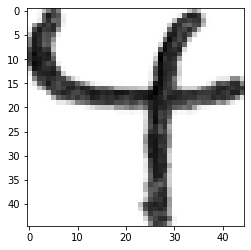

In [16]:
if __name__ == "__main__":
    main()